# **SIMPSONS CLASSIFICATION**
Computer Vision

<div align="center">
    <img src="./assets/homer.png" width=40% height=40%></img>
</div>

<!-- ![](./assets/homer.png) -->

Estrutura do *notebook*
- `[01]` Importando as bibliotecas;
- `[02]` Carregando os dados;
- `[03]` Informações dos dados carregados;
- `[04]` Redimensionando as imagens;
- `[05]` Aplicação de descritores nas imagens;
- `[06]` Balanceamento das classes;
- `[07]` Carregando os dados balanceados;
- `[08]` *Train-Test split*;
- `[09]` Reduzindo a dimensionalidade dos dados;
- `[10]` Criação do modelo;
- `[11]` Realizando uma votação a partir das predições;
- `[12]` Análise de erros e acertos;

# **IMPORTANDO BIBLIOTECAS**

In [3]:
import sys
sys.path.append('..')

import os
import cv2
import re
import pickle

from data_loader.load_data import ImagesLoader

from simpsons_classifier.voter import Voter as vote
import simpsons_classifier.load_stacking_models as stack
from simpsons_classifier.simpsons_classifier import SimpsonsClassifier

from utils.colors import Colors
from utils.plot_utils import *

from challenge.simpsons import *

import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC, SVR
from sklearn.neural_network import MLPClassifier

from sklearn.ensemble import RandomForestClassifier, \
                             StackingClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import skimage.feature as feature

from sklearn.metrics import accuracy_score, \
                            f1_score, \
                            classification_report, \
                            confusion_matrix, \
                            ConfusionMatrixDisplay
                            
import scikitplot as skplt

In [4]:
import warnings
warnings.filterwarnings('ignore')

# **CARREGANDO OS DADOS**

Os dados foram carregados utilizando a classe `ImagesLoader` do módulo `data_loader.load_data.py`, lendo as imagens de treino e teste a partir do caminho especificado. Os dados são armazenados em um dicionário (`dict`) que contém o nome dos arquivos, nomes dos personagens, caminhos dos arquivos, imagens originais, redimensionadas, descritores das imagens, entre outras variações. Trata-se de uma compilação de todos os dados a serem testados em diferentes modelos. No trecho abaixo, o objeto `loader` carrega todos os campos disponíveis (cuja respectiva descrição estará após o carregamento). Alternativamente, esses dados também podem ser carregados do disco a partir de um arquivo `pickle` que serializa o dicionário em questão, armazenado no mesmo diretório das imagens. Para tal fim, as imagens devem ser carregadas em memória através do módulo especificado, posteriormente tendo seus dados serializados e salvos em disco; o módulo `./data_loader.save_data.py` executa as ações descritas acima. 

In [7]:
# nome do diretório de imagens a serem utilizadas
DATASET_NAME = 'simpsons-small'

In [8]:
loader = ImagesLoader(train_images_path=f'./data/{DATASET_NAME}/train/',
                      test_images_path=f'./data/{DATASET_NAME}/test/')

# data = loader.load_data()

In [9]:
# alternativamente, carregar os dados a partir
# de um arquivo pickle serializado, do disco

with open(f'./data/{DATASET_NAME}/{DATASET_NAME}.pkl', 'rb') as infile:
    data = pickle.load(infile)

## Estrutura do dicionário com os dados
```python
data = {
    '<FIELD>': {
        'train' : np.array(['...']),
        'test' : np.array(['...'])
    },
    # demais campos
}
```

## Prefixos dos campos do dicionário
- `names_<FIELD>`: nomes de arquivos, caminhos ou personagens (vetores 1D);
- `images_<FIELD>`: matrizes das imagens (vetores 2D);
- `descriptor_<FIELD>`: *features* obtidas através de descritores ou histogramas de imagens (em geral, vetores 1D);
- `combination_<FIELD>`: combinações (concatenação com `np.hstack`) de descritores e histogramas entre si (em geral, vetores 1D);

## Descrições dos campos carregados no dicionário
- `names_files`: nome de cada um dos arquivos das imagens;
- `names_paths`: caminho de cada uma das imagens;
- `names_characters`: nome dos personagens de cada uma das imagens;
- `names_encoded`: nomes dos personagens codificados;
- `images_original`: matrizes das imagens originais; 
- `images_resized`: matrizes das imagens originais redimensionadas (mesmo `shape`);
- `images_gray`: matrizes das imagens em escala de cinza;
- `images_blue`: matrizes do canal azul das imagens RGB redimensionadas;
- `images_green`: matrizes do canal azulverde das imagens RGB redimensionadas;
- `images_red`: matrizes do canal vermelho das imagens RGB redimensionadas;
- `images_hsv`: matrizes das imagens convertidas para HSV;
- `images_h`: matrizes do canal H das imagens HSV de `images_hsv`;
- `images_s`: matrizes do canal S das imagens HSV de `images_hsv`;
- `images_v`: matrizes do canal V das imagens HSV de `images_hsv`;
- `images_lbp`: matrizes das imagens obtidas através do descritor LBP;
- `images_hu`: matrizes das imagens obtidas através do descritor *Hu moments*;
- `images_gabor`: matrizes das imagens obtidas através do descritor *Gabor*;
- `images_hog`: matrizes das imagens obtidas através do descritor HOG;
- `descriptor_blue`: histogramas do canal azul das imagens de `images_blue`;
- `descriptor_green`: histogramas do canal verde das imagens de `images_green`;
- `descriptor_red`: histogramas do canal vermelho das imagens de `images_red`;
- `descriptor_rgb`: histogramas concatenados dos histogramas azul, verde e veremelho das imagens;
- `descriptor_h`: histogramas do canal H das imagens de `images_h`;
- `descriptor_s`: histogramas do canal S das imagens de `images_s`;
- `descriptor_v`: histogramas do canal V das imagens de `images_v`;
- `descriptor_hsv`: histogramas concatenados dos histogramas H, S e V das imagens;
- `descriptor_lbp`: *features* obtidas a partir do descritor LBP;
- `descriptor_hu`: *features* obtidas a partir do descritor *Hu moments*;
- `descriptor_gabor`: *features* obtidas a partir do descritor *Gabor*;
- `descriptor_hog`: *features* obtidas a partir do descritor HOG;
- `combination_<FIELD1>+<FIELD2>+...`: concatenação de dois ou mais campos de descritores acima;

Maiores detalhes e exemplos do carregamento das imagens podem ser encontrados no *notebook* `./notebooks/load-data-examples.ipynb`.

# **INFORMAÇÕES DOS DADOS CARREGADOS**

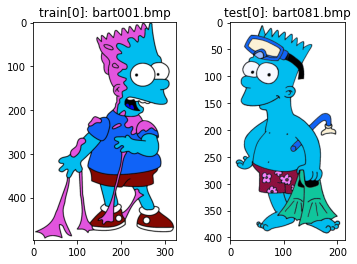

In [6]:
# primeira imagem original de treino e teste

fig, ax = plt.subplots(1, 2)

train_sample = data['images_original']['train'][0]
test_sample = data['images_original']['test'][0]

ax[0].imshow(train_sample);
ax[0].set_title('train[0]: ' + data['names_files']['train'][0]);

ax[1].imshow(test_sample);
ax[1].set_title('test[0]: ' + data['names_files']['test'][0]);

In [7]:
# quantidade de imagens de treino e teste

print('train/test')
data['images_original']['train'].shape, \
data['images_original']['test'].shape

train/test


((226,), (95,))

# **REDIMENSIONANDO AS IMAGENS**

Para conseguir utilizar modelos de Machine Learning nas imagens, como por exemplo criar um modelo a partir do *flatten* dos dados, é necessário redimensionar as imagens para mantê-las do mesmo tamanho. Para tal fim, foi utilizada a função `cv2.resize`, redimensionando as imagens de maneira a conseguir a menor distorção possível. O `shape` final das imagens foi obtido pela média de todos os comprimentos das imagens de treino e teste, bem como uma média de todas as alturas das imagens de treino e teste, obtendo um novo `shape` $(\overline{w}, \overline{h})$.

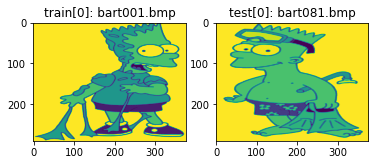

In [8]:
# primeira imagem redimensionada e em escala
# de cinza de treino e teste

fig, ax = plt.subplots(1, 2)

train_sample = data['images_gray']['train'][0]
test_sample = data['images_gray']['test'][0]

ax[0].imshow(train_sample);
ax[0].set_title('train[0]: ' + data['names_files']['train'][0]);

ax[1].imshow(test_sample);
ax[1].set_title('test[0]: ' + data['names_files']['test'][0]);

In [9]:
# novo shape das imagens
print(data['images_gray']['train'][0].shape)

(291, 375)


# **APLICAÇÃO DE DESCRITORES NAS IMAGENS**

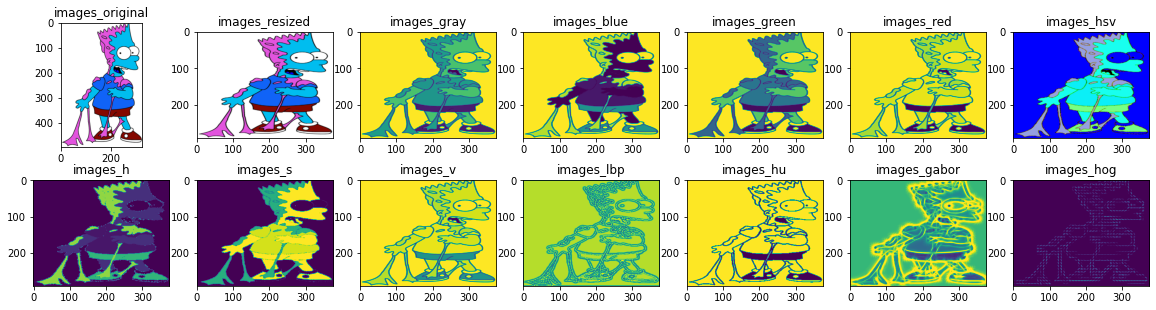

In [10]:
# campos do dicionário
fields = np.array(list(data.keys()))

# campos de imagens
images_fields = fields[
    np.where(
        np.array(list(map(lambda i: i if 'images' in i else 0, fields))) != '0'
    )
]

# exibindo imagens de descritores,
# canais RGB, HSV, enre outros
fig, ax = plt.subplots(2, len(images_fields)//2, figsize=(20,5))

for i in range(len(images_fields)):
    ax.ravel()[i].imshow(data[images_fields[i]]['train'][0]);
    ax.ravel()[i].set_title(images_fields[i]);

plt.savefig('./assets/descriptors.jpg');

Exemplos dos descritores utilizados, bem como gráficos de histogramas das imagens e visualizações das mesmas, podem ser encontradas no *notebook* `./notebooks/image-descriptors-examples.ipynb`

# **BALANCEAMENTO DAS CLASSES**

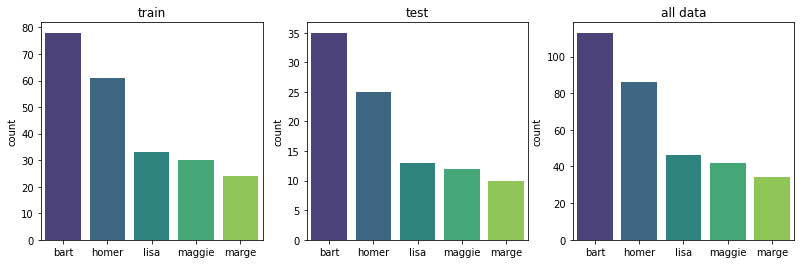

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(13.5,4))

train_characters = data['names_characters']['train']
test_characters = data['names_characters']['test']

sns.countplot(train_characters, palette='viridis', ax=ax[0]);
ax[0].set_title('train');

sns.countplot(test_characters, palette='viridis', ax=ax[1]);
ax[1].set_title('test');

sns.countplot(np.hstack([train_characters, test_characters]),
              palette='viridis',
              ax=ax[2]);
              
ax[2].set_title('all data');

Observamos que as classes são desbalanceadas, e isso dificulta muito o processo de predição dos modelos. Empiricamente, os resultados dos modelos nas etapas posteriores estavam fortemente enviesados pelas classes de maior predominância, então foram acrescentadas novas imagens das classes menos favorecidas, de maneira a tentar balancear a quantidade de exemplos de cada personagem. Além do mais, foram removidas algumas imagens fora do padrão usual dos personagens presentes nos dados de treino, de maneira a melhorar o desempenho dos classificadores, com amostras mais uniformes e próximas entre si, facilitando a aprendizagem. As novas imagens mencionadas foram retiradas do [The Simpsons Character Data (Kaggle)](https://www.kaggle.com/datasets/alexattia/the-simpsons-characters-dataset), e seu acréscimo resultou em um novo conjunto de dados, intitulado `simpsons-small-balanced` e armazenado no diretório de mesmo nome, em `./data/`.

# **CARREGANDO OS DADOS BALANCEADOS**

In [5]:
DATASET_NAME = 'simpsons-small-balanced'

In [6]:
loader = ImagesLoader(train_images_path=f'./data/{DATASET_NAME}/train/',
                      test_images_path=f'./data/{DATASET_NAME}/test/')

# data = loader.load_data()

In [7]:
# alternativamente, carregar os dados a partir
# de um arquivo pickle serializado, do disco

with open(f'./data/{DATASET_NAME}/{DATASET_NAME}.pkl', 'rb') as infile:
    data = pickle.load(infile)

## Informações dos dados carregados

In [34]:
# nova quantidade de imagens de treino e teste

print('train/test')
data['images_original']['train'].shape, \
data['images_original']['test'].shape

train/test


((324,), (95,))

In [35]:
# novo shape das imagens, obtido pela média
# de todos os comprimentos e todas as larguras
# (incluindo as novas imagens adicionadas)

data['images_gray']['train'][0].shape

(315, 390)

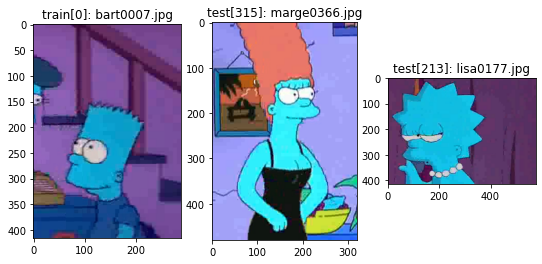

In [36]:
# exemplos de novas imagens adicionadas

fig, ax = plt.subplots(1, 3, figsize=(9,4))

train_sample1 = data['images_original']['train'][0]
train_sample2 = data['images_original']['train'][315]
train_sample3 = data['images_original']['train'][213]

ax[0].imshow(train_sample1);
ax[0].set_title('train[0]: ' + data['names_files']['train'][0]);

ax[1].imshow(train_sample2);
ax[1].set_title('test[315]: ' + data['names_files']['train'][315]);

ax[2].imshow(train_sample3);
ax[2].set_title('test[213]: ' + data['names_files']['train'][213]);

In [49]:
# novas quantidades de exemplos
# de cada classe

pd.Series(data['names_characters']['train']).value_counts()

bart      81
homer     80
lisa      75
marge     59
maggie    29
dtype: int64

# **TRAIN-TEST SPLIT**

Foram separados apenas os rótulos de treino e teste (`y_train` e `y_test`), pois serão treinados diferentes modelos, cada um com dados de diferentes campos do dicionário; tais campos estão listados abaixo em `FIELDS`. Essa separação visa um maior desempenho do modelo final criado, buscando treinar os modelos com os dados que melhor lhes competem. 

Para poder utilizar os dados nos modelos, os nomes dos personagens foram codificados da seguinte maneira:
```python
encoded_labels = {
    'bart': 0,
    'homer': 1,
    'lisa': 2,
    'marge': 3,
    'maggie': 4
}
```

In [8]:
# campos de dados a serem utilizados nos modelos

FIELDS = [
    'combination_hsv+hu',
    'descriptor_hsv'
]

In [9]:
# shape dos dados

print('field = (train)/(test)')

print('names_characters =',
      np.array(data['names_characters']['train']).shape,
      np.array(data['names_characters']['test']).shape, end='\n\n')

for field in FIELDS:
              
      print(f'{field} shape =',
            np.array(data[field]['train']).shape,
            np.array(data[field]['test']).shape)

field = (train)/(test)
names_characters = (324,) (95,)

combination_hsv+hu shape = (324, 775) (95, 775)
descriptor_hsv shape = (324, 768) (95, 768)


In [10]:
# train-test split

X_train = [data[field]['train'] for field in FIELDS]
y_train = data['names_encoded']['train']

X_test = [data[field]['test'] for field in FIELDS]
y_test = data['names_encoded']['test']

print('len(X_train) =', len(X_train),
      '\nlen(X_test) =', len(X_test))

print(y_train.shape, y_test.shape)

len(X_train) = 2 
len(X_test) = 2
(324,) (95,)


# **REDUZINDO A DIMENSIONALIDADE DOS DADOS**

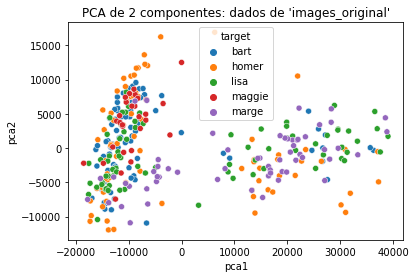

In [54]:
# carregando os dados do campo específico
X_train_pca = data['images_gray']['train']
X_train_pca = X_train_pca.reshape(len(X_train_pca),-1)

# pca de 2 componentes
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(X_train_pca)

df_pca = pd.DataFrame()
df_pca['pca1'] = reduced_data[:, 0]
df_pca['pca2'] = reduced_data[:, 1]
df_pca['target'] = data['names_characters']['train']

# plotagem 2d
sns.scatterplot(data=df_pca,
                x='pca1',
                y='pca2',
                hue='target');

plt.title(f"PCA de 2 componentes: dados de 'images_original'");

Observamos que a redução da dimensionalidade dos dados das imagens originais, em escala de cinza, para 2 componentes utilizando o PCA, demonstrou uma confusão no espaço de decisão: as classes estão misturadas, com dificuldades para se traçar planos de corte para classificação. Em cada matriz de duas dimensões, foi feito um `reshape` para um vetor unidimensional, de maneira a possibilitar a utilização do PCA.

Abaixo, segue a aplicação do PCA nos campos listados acima, a serem utilizados nos modelos nas etapas posteriores.

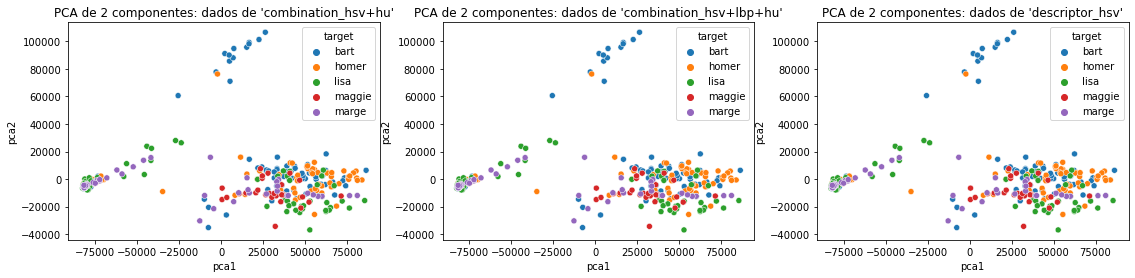

In [55]:
fig, ax = plt.subplots(1, len(FIELDS), figsize=(19,4))

for i, field in enumerate(FIELDS):
    # carregando os dados do campo específico
    X_train_pca = data[field]['train']

    # pca de 2 componentes
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(X_train_pca)

    df_pca = pd.DataFrame()
    df_pca['pca1'] = reduced_data[:, 0]
    df_pca['pca2'] = reduced_data[:, 1]
    df_pca['target'] = data['names_characters']['train']

    # plotagem 2d
    sns.scatterplot(data=df_pca,
                    x='pca1',
                    y='pca2',
                    hue='target',
                    ax=ax[i]);

    ax[i].set_title(f"PCA de 2 componentes: dados de '{field}'");

Observamos um maior separamento das classes no plano, evidenciando um maior potencial na classificação das amostras.

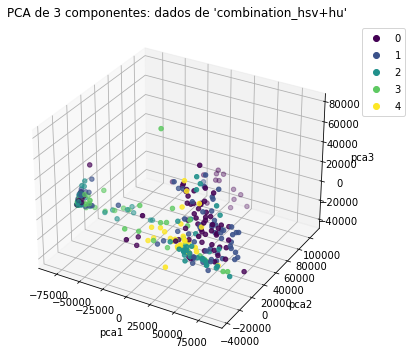

In [56]:
# carregando os dados do campo específico
X_train_pca = data['combination_hsv+hu']['train']

# pca de 3 componentes
pca = PCA(n_components=3)
reduced_data = pca.fit_transform(X_train_pca)

df_pca = pd.DataFrame()
df_pca['pca1'] = reduced_data[:, 0]
df_pca['pca2'] = reduced_data[:, 1]
df_pca['pca3'] = reduced_data[:, 2]
df_pca['target'] = data['names_encoded']['train']

# plotagem 3d
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel('pca1')
ax.set_ylabel('pca2')
ax.set_zlabel('pca3')

plot_3d = ax.scatter(df_pca['pca1'],
                     df_pca['pca2'],
                     df_pca['pca3'],
                     c=df_pca['target'],
                     cmap='viridis')

plt.legend(*plot_3d.legend_elements(),
            bbox_to_anchor=(1.05, 1),
            loc=2)

plt.title(f"PCA de 3 componentes: dados de 'combination_hsv+hu'");
plt.show();

Acima, observamos o plano 3D do PCA de 3 componentes dos dados de `combination_hsv+hu`, visualizados também (parcialmente) no plano 2D acima.
Abaixo, temos a visualização dos diferentes planos da figura acima.

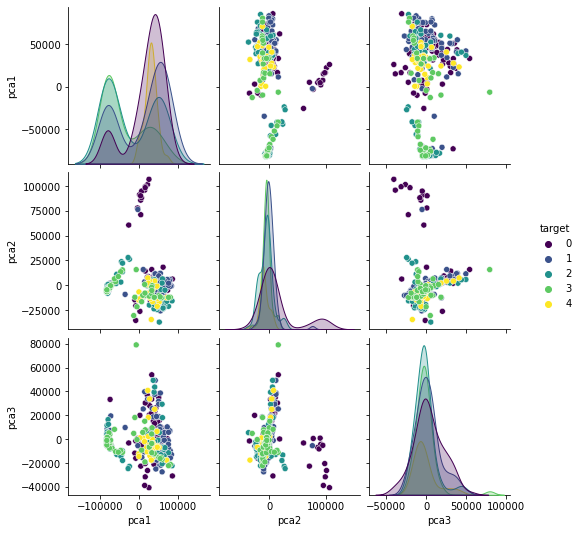

In [57]:
# visualizando os planos
sns.pairplot(df_pca, hue='target', palette='viridis');

# **EXECUÇÃO DAS PIPELINES**

## *Pipelines* de modelos
A escolha dos dados que serão utilizados por cada modelo não foi completamente aleatória. Previamente, foram executadas várias *pipelines* de modelos, para cada um dos campos de dados carregados (exceto os dados das imagens em si, apenas descritores, histogramas e combinações). Em cada um dos modelos testados, foi utilizado o objeto `Pipeline` do `sklearn`, criando uma *pipeline* com o modelo em si e um `StandardScaler`, normalizando os dados entre 0 e 1, e então conduzindo o processo (treino e teste). Além do mais, cada *pipeline* utilizou os seguintes modelos:
- `KNeighborsClassifier()`
- `GaussianNB()`
- `LinearSVC()`
- `SVC()`
- `LogisticRegression()`
- `RandomForestClassifier()`
- `LGBMClassifier()`
- `XGBClassifier()`
- `AdaBoostClassifier()`
- `ExtraTreesClassifier()`
- `MLPClassifier()`
- `DummyClassifier(strategy='stratified')`

## `Dummy classifier` 
O último modelo (`DummyClassifier`) consiste em um modelo aleatório, utilizado como *baseline* de comparação para os demais classificadores. Esse modelo utiliza a estratégia `stratified`, consistindo em uma escolha das classes proporcional à quantidade de exemplos. Em suma, se existem mais *Homers* nas imagens de treino, esse proporção irá se refletir na proporção de Homers classificados em teste. Essa estratégia permite alcançar maiores acurácias globais, uma vez que tende a acertar mais as classes mais predominantes, e isso o torna um *baseline* relativamente eficaz.

## Executando as *pipelines*
Para executar um experimento, basta utilizar o módulo `experiments.ml_pipeline.py`, especificando o conjunto de dados que se deseja utilizar, bem como o campo do dicionário que será utilizado. Sua execução será detalhada no *terminal*, e ao fim será registrado um `log` em `./logs/<NOME_DO_DATASET>`, relatando o status da execução e outras informações.

Exemplos de execuções das *pipelines* podem ser encontradas no formato de *notebooks*, descrevendo passo a passo e de maneira visual as etapas realizadas. Os notebooks mencionados são (disponíveis em `./notebooks/`):
- `ml-pipeline-descriptor-hu-example-large.ipynb`: utilizando o descritor *Hu moments* no *dataset* maior;
- `ml-pipeline-descriptor-lbp-example.ipynb`: utilizando o descritor LBP no *dataset* original;
- `ml-pipeline-images-resized-example.ipynb`: utilizando as imagens originais redimensionadas e em escala de cinza no *dataset* original;

## Experimentos executados
De maneira a criar o classificador final, foram executadas 34 *pipelines* para cada conjunto de imagens, totalizando 68 execuções. Ademais, também foram executadas as *pipelines* com os dados (matriciais) das imagens, porém devido ao baixo desempenho geral, esses resultados não foram diretamente utilizados (uma vez também que o custo computacional de cada execução foi elevado). Para cada execução, além do `log`, foram registradas:
- Matrizes de confusão de cada modelo, armazenadas em `./images/<NOME_DO_DATASET>/pipeline_<NOME_DO_CAMPO>_cm.jpg`;
- Um arquivo `csv` contendo o `classification_report` de cada modelo, concatenando todos os *reports* em um só arquivo; esses arquivos foram armazenados em `./output/<NOME_DO_DATASET>/pipeline_<NOME_DO_CAMPO_results.csv>`;

A análise dos resultados obtidos, como por exemplo modelos que melhor desempenharam, ou então melhores descritores (ou combinações de descritores), pode ser encontrada no *notebook* `./notebooks/model-results-analysis.ipynb`.

## Métrica utilizada
Por fim, a condução desses experimentos tornou mais claro o entendimento de quais modelos desempenham melhor em quais conjuntos de dados, bem como quanto esses modelos conseguem performar. Em geral, a execução dos modelos instanciados sem demais ajustes, treinados nos dados originais das imagens (`ravel`), obtiveram resultados próximos de 50% de acurácia. Contudo, a métrica escolhida para avaliar os modelos foi o F1 *score*, mais precisamente a média ponderada entre os F1 *scores* (**weighted F1**) das diferentes classes.

## Setup das *stacks*

O modelo criado utilizou classificadores `StackingClassifier`, combinando diversos estimadores e melhorando seu poder preditivo. A função `load_stacking_models` carrega tais classificadores instanciados, respectivamente seguindo a configuração abaixo:

```python
# campos de cada stacking classifier
fields = [
    'combination_hsv+hu',
    'combination_hsv+lbp+hu',
    'descriptor_hsv'
]

# estimadores finais de cada stacking classifier
final_estimators = [
    XGBClassifier(random_state=42),
    LinearSVC(random_state=42),
    LGBMClassifier(random_state=42)
]

# estimadores de cada stacking classifier
estimators = [
    ('lsvc', LinearSVC(random_state=42)),
    ('mlp', MLPClassifier(random_state=42)),
    ('lr', LogisticRegression(random_state=42)),
    ('xgb', XGBClassifier(random_state=42)),
    ('lgbm', LGBMClassifier(random_state=42))
]
```

Portanto, foram criadas três *stacks*, treinadas respectivamente com os campos `combination_hsv+hu`, `combination_hsv+lbp+hu` e `descriptor_hsv`. Cada *stack* terá como estimador final o classificador correspondente da lista `final_estimators`. Cada *stack* será composta por todos os estimadores listados.

$$F1 = 2 \cdot \frac{precision \cdot recall}{precision + recall}$$
$$\overline{F1} = \frac{(F1_x \cdot |x|) + (F1_y \cdot |y|) + \dots}{x + y + \dots}$$
$$\overline{F1} = \left( \sum_{i=0}^{n}F1_{k_i} \cdot |k_i| \right) \cdot \left( \sum_{i=0}^{n} \frac{1}{k_i} \right), \ \ k=\{x, \ y, \ z, \dots\}$$

Onde
- $k$: Conjunto das classes;
- $x$: Classe $x$;
- $|x|$: Cardinalidade da classe $x$, ou seja, número de exemplos que a compõe;

# **RESULTADOS OBTIDOS**

Segue abaixo a leitura da tabela sumarizada com os resultados das *pipelines*.

In [10]:
# lendo tabela sumarizada de resultados
df = pd.read_csv(
    './output/simpsons-small-balanced/classification-report-summary.csv'
)

# resultados dos modelos clássicos
df_models = df[~((df['model'].str.contains('vote')) | \
                 (df['model'].str.contains('stk')) | \
                 (df['model'].str.contains('bag')))]

# resultados dos ensembles
df_ensemb = df[((df['model'].str.contains('vote')) | \
                (df['model'].str.contains('stk')) | \
                (df['model'].str.contains('bag')))]

## `f1-score` por modelo (clássico) utilizado

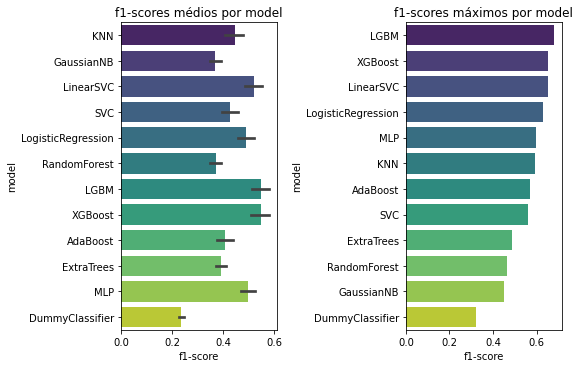

In [13]:
# f1-score por modelo utilizado
plot_scores_by_col(col='model', df=df_models, figsize=(8,5))

## `f1-score` por campo utilizado

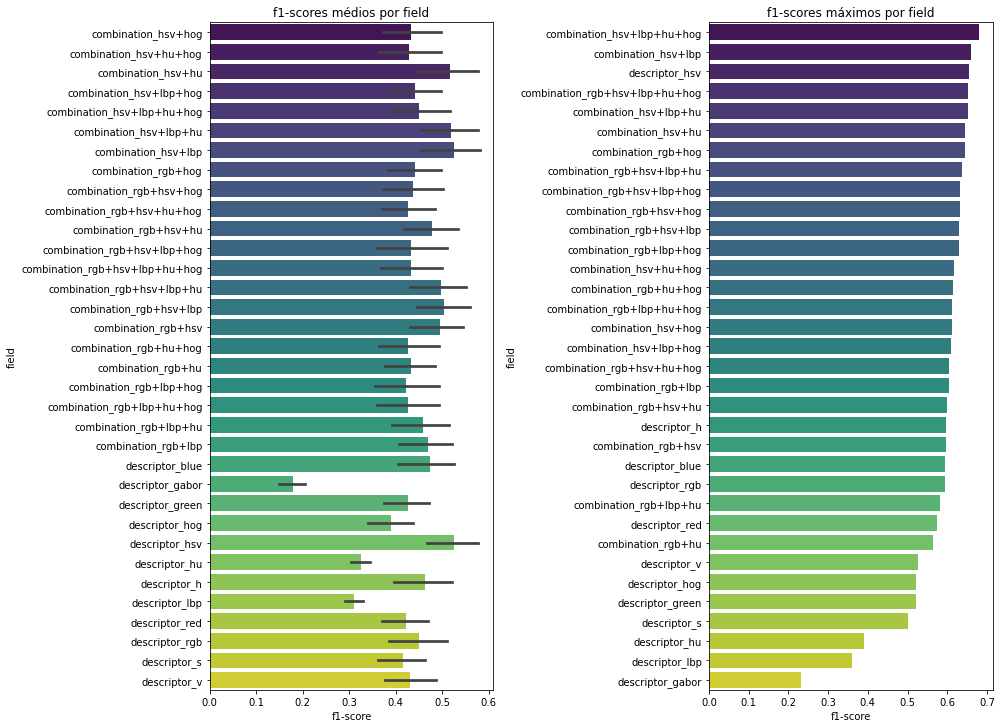

In [14]:
# f1-score por field utilizado
plot_scores_by_col(col='field', df=df_models)

## `f1-score` por modelo (*ensemble*) utilizado

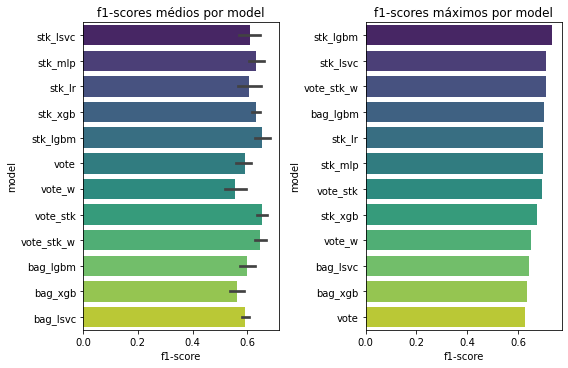

In [15]:
# f1-score por modelo (ensemble) utilizado
plot_scores_by_col(col='model', df=df_ensemb, figsize=(8,5))

# **CRIANDO O MODELO** `SimpsonsClassifier`

In [22]:
# carregando modelos instanciados
stacks = stack.load_stacking_models(fields=FIELDS)

# cada campo representa uma stack
list(stacks.keys())

['combination_hsv+hu', 'descriptor_hsv']

In [13]:
# criação e treinamento do modelo

simp = SimpsonsClassifier(stack_models=stacks)
simp.fit(X_train, y_train)
preds = simp.predict(X_test)

In [14]:
for field in FIELDS:
    print(field)
    print(classification_report(y_test, preds[field]))

combination_hsv+hu
              precision    recall  f1-score   support

           0       0.75      0.94      0.84        35
           1       0.77      0.80      0.78        25
           2       0.78      0.54      0.64        13
           3       0.86      0.60      0.71        10
           4       0.89      0.67      0.76        12

    accuracy                           0.78        95
   macro avg       0.81      0.71      0.74        95
weighted avg       0.79      0.78      0.77        95

descriptor_hsv
              precision    recall  f1-score   support

           0       0.75      0.94      0.84        35
           1       0.77      0.92      0.84        25
           2       0.86      0.46      0.60        13
           3       1.00      0.70      0.82        10
           4       1.00      0.58      0.74        12

    accuracy                           0.80        95
   macro avg       0.87      0.72      0.77        95
weighted avg       0.83      0.80      0.79

# **REALIZANDO UMA VOTAÇÃO A PARTIR DAS PREDIÇÕES**

Os modelos `StackingClassifier` gerados forneceram três versões distintas das predições. Para unificar seus resultados, foi conduzida uma votação, em que os votos da maioria definiram a predição de cada caso.

As votações aceitam pesos, seja um peso atribuído às predições de uma *stack* (vetor 1D de pesos), ou então uma predição específica para cada classe (vetor 2D de pesos). Por exemplo, caso sejam atribuídos os pesos `[1,1,2]`, o terceiro classificador (terceira *stack*) terá sua predição contando como duas (pois possui um peso 2); em outra situação, caso os pesos fornecidos fossem

<div align="center">
    <code>[[1,1,1],</code><br>
    &nbsp;&nbsp;<code>[1,1,1],</code><br>
    &nbsp;&nbsp;<code>[1,1,1],</code><br>
    &nbsp;&nbsp;<code>[1,1,1],</code><br>
    &nbsp;&nbsp;<code>[1,1,2]]</code>
</div>

então temos pesos diferentes para cada classe: cada classe respectiva à posição dos pesos, seguirá tal configuração. No exemplo passado, a classe 4 - *maggie* - (posição 4 na matriz) seguirá os pesos `[1,1,2]`, atribuindo um peso maior ao terceiro classificador para esse personagem.

O trecho abaixo gerou matrizes de pesos aleatórias, repetindo o processo 10000 vezes e calculando o **F1 weighted**, retornando a melhor configuração.

## Otimizando os pesos do modelo

In [17]:
# pesos aleatórios; scores obtidos (f1)
random_weights = []
weighted_f1 = []

# gerando 10000 matrizes aleatórias de pesos
for i in range(10000):
    weights = [[random.randint(1,3) for i in range(3)] for i in range(5)]

    # realizando a votação
    y_pred_election = vote.hard_voting(args=list(preds.values()),
                                       weights=weights)

    weighted_f1.append(
        f1_score(y_test, y_pred_election, average='weighted')
    )

    random_weights.append(weights)

# index do melhor score
idx = np.argmax(weighted_f1)
weights = random_weights[idx]

print('best weight f1 =', weighted_f1[idx])
print('weights')
print(weights)

best weight f1 = 0.8252712589554696
weights
[[1, 1, 1], [1, 2, 2], [3, 3, 1], [2, 2, 2], [3, 2, 3]]


In [ ]:
# # pesos para cada campo e cada classe
# # caso não rode a otimização

# weights = [[1, 1, 1],
#            [1, 2, 2],
#            [3, 3, 1],
#            [2, 2, 2],
#            [3, 2, 3]]

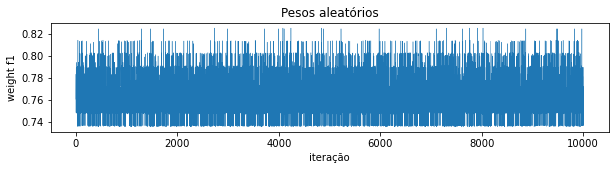

In [19]:
# oscilações do weighted f1 ao longo da
# geração de pesos aleatórios

plt.figure(figsize=(10,2));

plt.title('Pesos aleatórios');
plt.xlabel('iteração');
plt.ylabel('weight f1');
plt.plot(weighted_f1, linewidth=.4);

## Realizando as predições

In [20]:
# realizando uma votação entre as três
# listas de predições distintas de cada stack

y_pred = vote.hard_voting(list(preds.values()),
                          weights=weights)

y_pred

array([0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 4, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 2, 0, 1,
       0, 2, 2, 1, 1, 2, 2, 4, 4, 2, 4, 1, 4, 4, 4, 4, 4, 0, 0, 3, 3, 3,
       3, 3, 1, 3, 3, 3, 0])

              precision    recall  f1-score   support

           0       0.82      0.94      0.88        35
           1       0.79      0.92      0.85        25
           2       0.78      0.54      0.64        13
           3       1.00      0.80      0.89        10
           4       0.89      0.67      0.76        12

    accuracy                           0.83        95
   macro avg       0.86      0.77      0.80        95
weighted avg       0.84      0.83      0.83        95



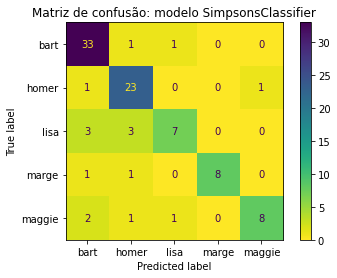

In [39]:
# resultados do modelo

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
cm_plot = ConfusionMatrixDisplay(cm, display_labels=loader.labels)
cm_plot.plot(cmap='viridis_r');
plt.title('Matriz de confusão: modelo SimpsonsClassifier');

# plt.savefig('./assets/cm.jpg');

Após as votações, o modelo conseguiu um valor de **0.83** para o **weighted avg f1-score**, demonstrando uma boa capacidade de discriminação entre as classes, bem como uma melhora considerável em relação aos experimentos iniciais realizados.

# **ANÁLISE DE ERROS E ACERTOS**

Abaixo, segue uma listagem dos erros e acertos do modelo.

In [33]:
def plot_cases(y_pred_election,
               y_test,
               images,
               case='erros',
               figsize=(18,13)):
    # lista de classificações com acertos/erros
    elements = []
    for pred, true, img in zip(y_pred_election,
                               y_test,
                               images):
        if case == 'acertos':
            if pred == true:
                elements.append((img, true, pred))

        elif case == 'erros':
            if pred != true:
                elements.append((img, true, pred))

    root = np.sqrt(len(elements))
    size = int(root)

    fig, ax = plt.subplots(size, size+2, figsize=figsize)

    # título
    fig.text(x=.5,
             y=.92,
             s=f"{case.capitalize()} do modelo; total de {case} = {len(elements)} de " \
               f"{len(images)} amostras",
             horizontalalignment='center',
             verticalalignment='top',
             fontsize=16)

    # exibindo os acertos/erros
    for pack in enumerate(elements):
        try:
            i = pack[0]
            img = pack[1][0]
            true = pack[1][1]
            pred = pack[1][2]

            ax.ravel()[i].imshow(img, cmap='binary');
            ax.ravel()[i].set_title(f'true={loader.decoded_labels[true]}; ' \
                                    f'pred={loader.decoded_labels[pred]}');
        except:
            pass

## Erros do modelo

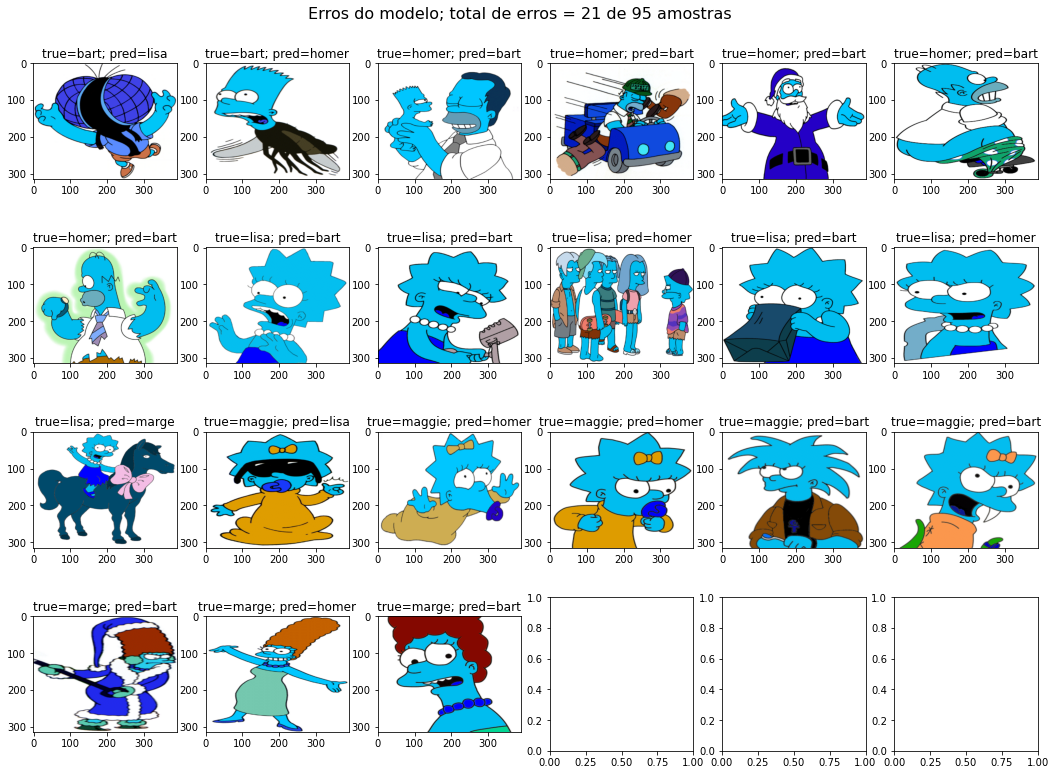

In [35]:
plot_cases(
    y_pred_election=y_pred_election,
    y_test=y_test,
    images=data['images_resized']['test'],
    case='erros'
)

## Acertos do modelo

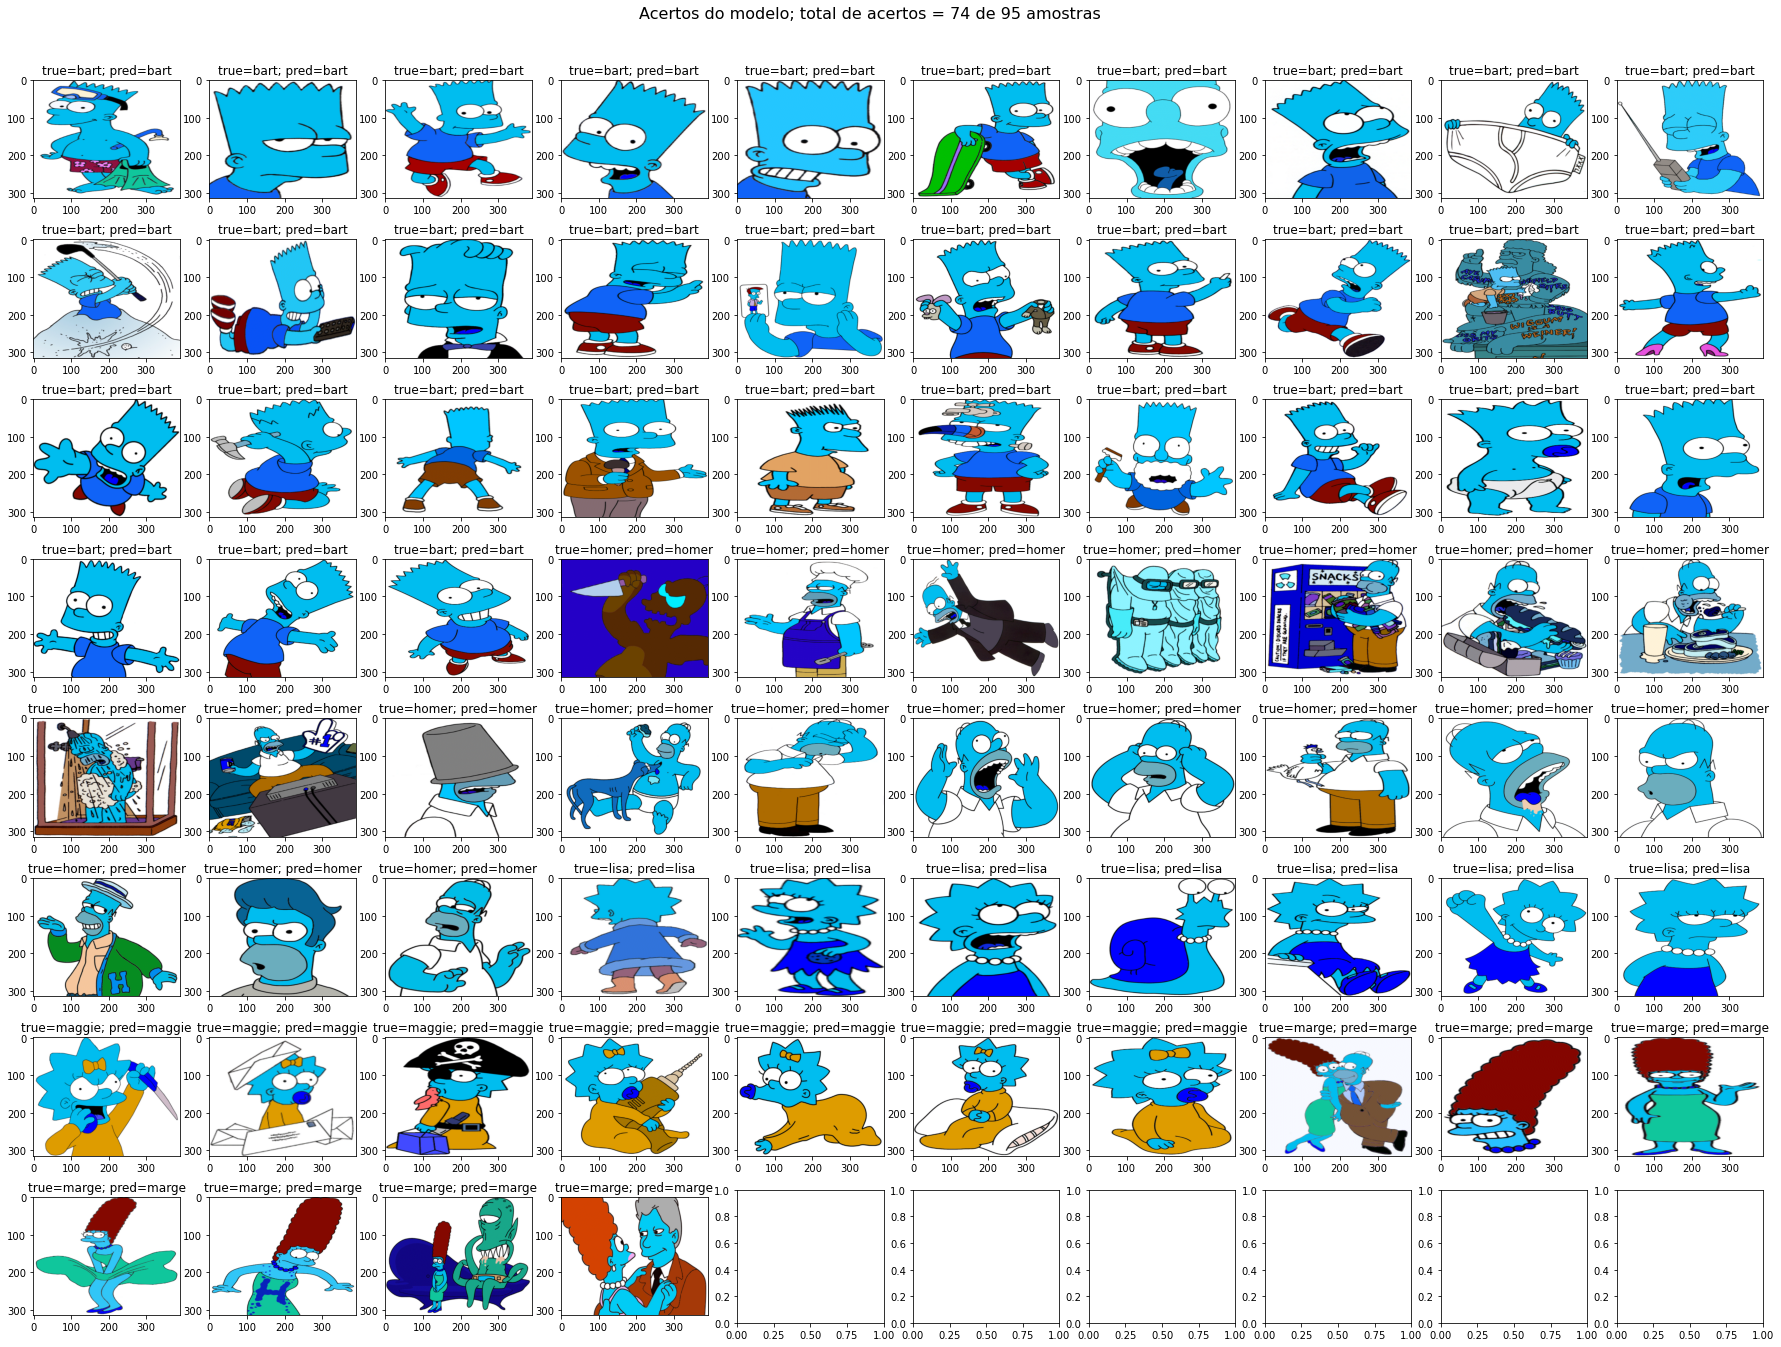

In [37]:
plot_cases(
    y_pred_election=y_pred_election,
    y_test=y_test,
    images=data['images_resized']['test'],
    case='acertos',
    figsize=(31,23)
)